In [36]:
#restart the kernel if switching from inline to notebook
import matplotlib.pyplot as plt
%matplotlib notebook 
plt.style.use('seaborn-whitegrid')
import corner

import numpy as np
import numpy.linalg
import scipy.stats
from scipy.signal import argrelextrema
import pandas as pd

import emcee
import george

from subsample import subsample # daniela's code
from emcee_utils import walker_params, plot_gpfit
#from plotting import plot_steps
from plotting import plot_lightcurve, plot_folded_lightcurve, plot_mcmc_sampling_results, plot_steps

In [37]:
txt = "../data/6478_CFHT_2005_04_03_lightcurve_mjd_utc_light_time_corrected_r_magnitude_r_magnitude_error_v2.txt"
data = pd.read_csv(txt, delim_whitespace=True)

In [38]:
data.head()

,date_MJD_UTC,mag,mag_unc
0,53463.252928,17.888299,0.005041
1,53463.257279,17.899499,0.004872
2,53463.261319,17.911499,0.005194
3,53463.273553,17.928699,0.004872
4,53463.280127,17.858799,0.005213


In [39]:
tsample = data.date_MJD_UTC
fsample = data.mag
flux_err = data.mag_unc

<IPython.core.display.Javascript object>


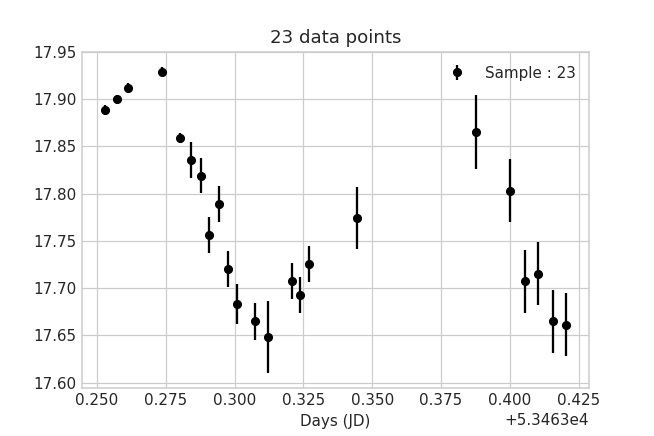

In [40]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title("%i data points"%(len(fsample)))
ax.set_xlabel("Days (JD)")
ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5,
            color="black", zorder=10, 
            label="Sample : " + str(len(tsample)))
ax.legend()

In [6]:
(tsample.iloc[-1]-tsample[0])*24

4.019166666897945

In [41]:
def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    param[0] : float
        mean (between 0 and 2)

    param[1] : float
        log amplitude (between -10 and 10)

    param[2] : float
        gamma (log gamma between 0.1 and 40)

    param[3] : float
        log period (period between 1h and 24hrs)

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    p_mean = scipy.stats.norm(17.75, 0.5).logpdf(params[0])
    #p_log_amp = scipy.stats.uniform(-10,30).logpdf(params[1])
    p_log_amp = scipy.stats.norm(np.log(0.15), np.log(2)).logpdf(params[1])
    p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    ###print this line to get the prob value: p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    #p_period = scipy.stats.uniform(np.log(1./24.), -np.log(1./24.)).logpdf((params[3]))
    #p_period = scipy.stats.halfnorm(loc=np.log(0.5/24.), scale=np.exp(0.5/24.)).logpdf(params[3])
    p_period = scipy.stats.halfcauchy(loc=np.log(0.5/24.), scale=np.exp(0.5/24.)).logpdf(params[3])
    #p_period = scipy.stats.norm(np.log(4./24.), (12./24.)).logpdf(params[3])
    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior

def logl(params, gp, tsample, fsample, flux_err):
    # compute lnlikelihood based on given parameters
    gp.set_parameter_vector(params)

    try:
        gp.compute(tsample, flux_err)
        lnlike = gp.lnlikelihood(fsample)
    except np.linalg.LinAlgError:
        lnlike = -1e25
    return lnlike

def post_lnlikelihood(params, gp, tsample, fsample, flux_err):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """

    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    try:
        lnlike = logl(params, gp, tsample, fsample, flux_err)
        ln_likelihood = lnlike+log_prior

    except np.linalg.linalg.LinAlgError:
        ln_likelihood = -1e25

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25

In [42]:
ndim, nwalkers = 4, 100

In [43]:
# initialize walker parameters
gp_mean = np.mean(fsample)
log_amp = np.log(fsample.max()-fsample.min())
gamma = 1
log_period = np.log(0.5)

params = [np.mean(fsample), log_amp, gamma, log_period]

# set up gp kernel
kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
gp = george.GP(kernel, fit_mean=True, mean=gp_mean)
gp.compute(tsample, flux_err)

# equally distributed starting period values
p_start = np.array(params)/100.
cov_matrix = np.sqrt(np.diag(p_start)**2)
p0 = np.random.multivariate_normal(mean=params, cov=cov_matrix, size=(nwalkers))
x = np.log(np.linspace(2,12,nwalkers)/24.)
p0[:,3] = x


In [52]:
threads=8
sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[gp, tsample, fsample, flux_err], threads=threads)

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp

In [53]:
%%time
mcmc_sampling = sampler.run_mcmc(p0, 60000)

CPU times: user 29min 33s, sys: 2min 28s, total: 32min 2s
Wall time: 1h 33min 42s


<IPython.core.display.Javascript object>


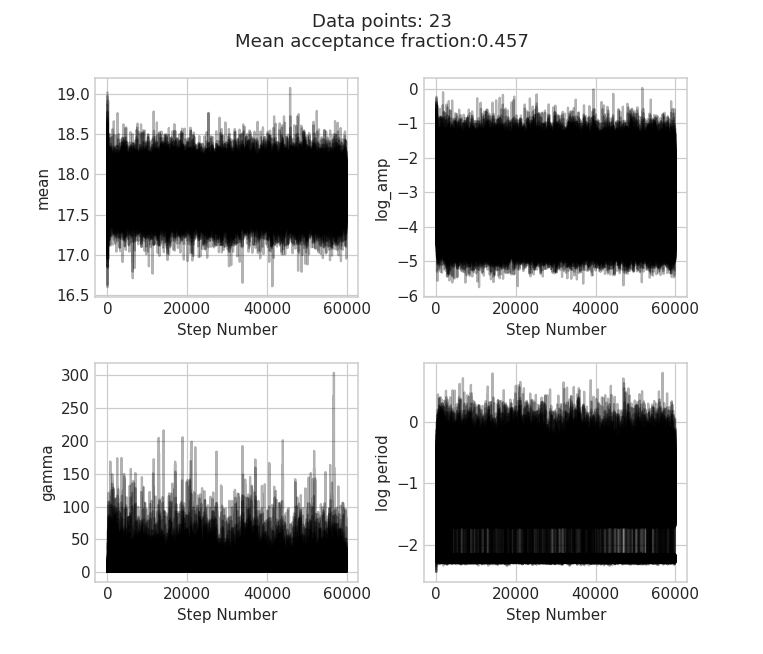

In [54]:
plot_steps(sampler, dims = ['mean', 'log_amp', 'gamma', 'log period'], p0=[params], data_pts=len(fsample))

<IPython.core.display.Javascript object>


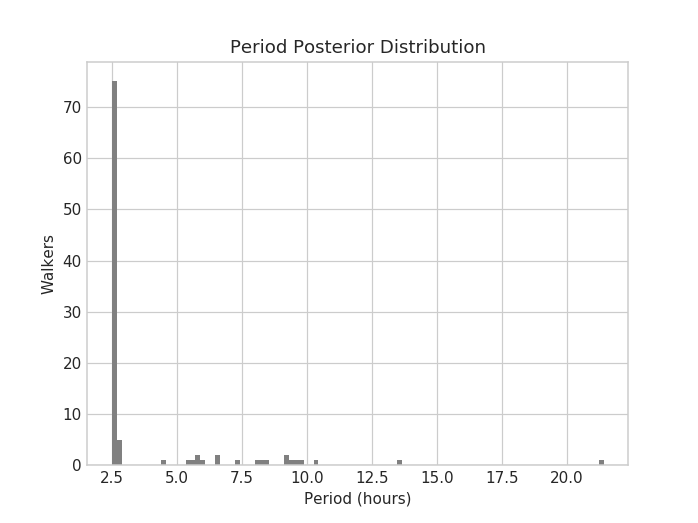

Text(0.5,0,'Period (hours)')

In [55]:
# sampler.chain[chain, step, dimension]
end_period = sampler.chain[:,-1,-1]
end_period.sort()

fig, fx = plt.subplots(1,1)
fx.hist(np.exp(end_period)*24., bins=100, color='grey')
fx.set_title('Period Posterior Distribution')
fx.set_ylabel('Walkers')
fx.set_xlabel('Period (hours)')

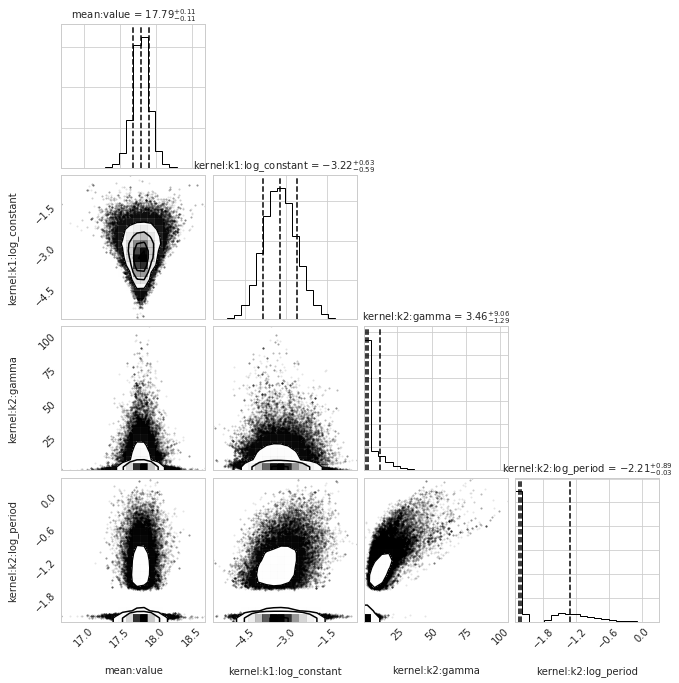

In [15]:
# make some labels
labels = list(gp.get_parameter_names())
#labels[3] = 'period'

# percentage of steps to plot
percent = 0.1

# generate list of last steps spanning backwards
x = list(range(-1,-int(sampler.iterations*percent)-1,-1))

# only plot x last steps
# reshape into 2d array instead of 3d
#sampler.chain[walker, step, param]
figure = corner.corner(sampler.chain[:,x,:].reshape(int(sampler.iterations*percent*sampler.k),4), 
                       labels=labels, quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 10})

The distribution of periods ended up looking like this.

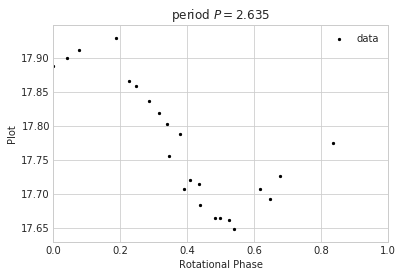

In [16]:
periods = np.exp(sampler.chain[:,-1,-1])
best_period = np.median(periods)
plot_folded_lightcurve(tsample, fsample, best_period)

We can now see how the different posterior distributions model the original sampled data. Feel free to give the file names **namestr** an appropriate title.

In [ ]:
def save_chain(file_name, sampler):
        header = str(sampler.chain.shape)
        np.savetxt(file_name, sampler.flatchain, header=header)
        return

filename = "5318_new_priors"

save_chain(filename + "_results.txt", sampler)

[17.70527273 -2.62665566  7.90313142 -0.97701943]
[17.8359759  -3.06373849  3.53326748 -2.25502026]
[17.825159   -4.53282526  2.0118841  -2.22767607]
[17.78714432 -4.12452671 23.94357131 -0.89588617]
[17.77202567 -2.1176442   2.07592125 -2.22434338]
[17.66787632 -2.86225634  1.71113265 -2.21901869]
[17.89138594 -3.47106466  7.39489064 -1.60110874]
[17.75948696 -4.13203281  9.77970387 -1.48052471]
[17.7753992  -3.33391485 16.12294025 -0.79045444]
[17.64755706 -3.57264734  3.19600219 -2.23277187]


<IPython.core.display.Javascript object>


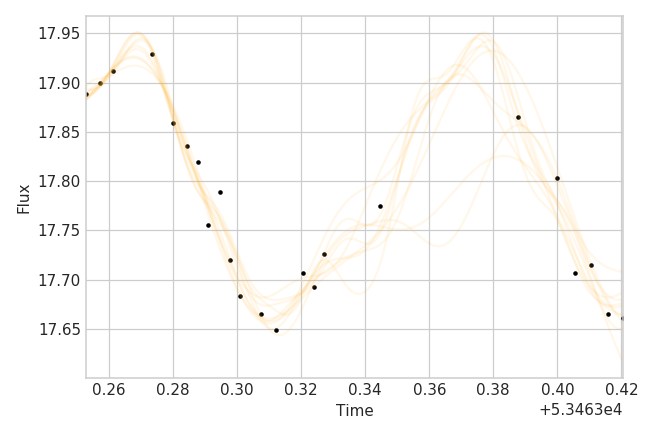

<IPython.core.display.Javascript object>


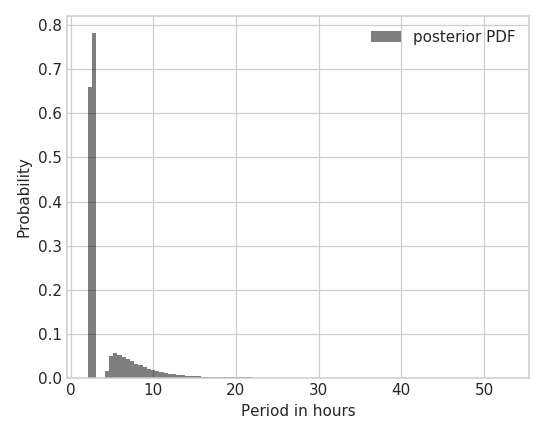

<IPython.core.display.Javascript object>


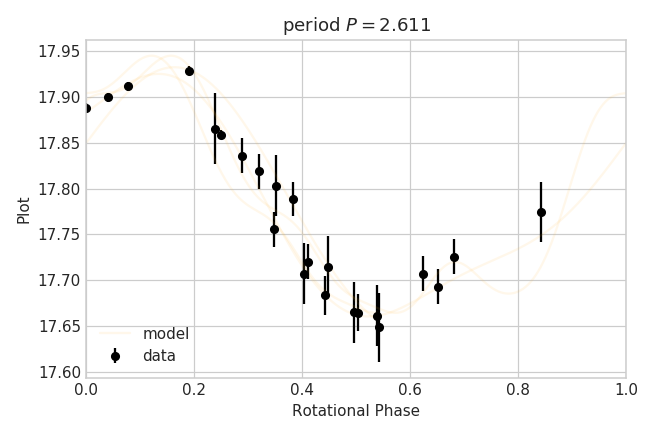

<IPython.core.display.Javascript object>


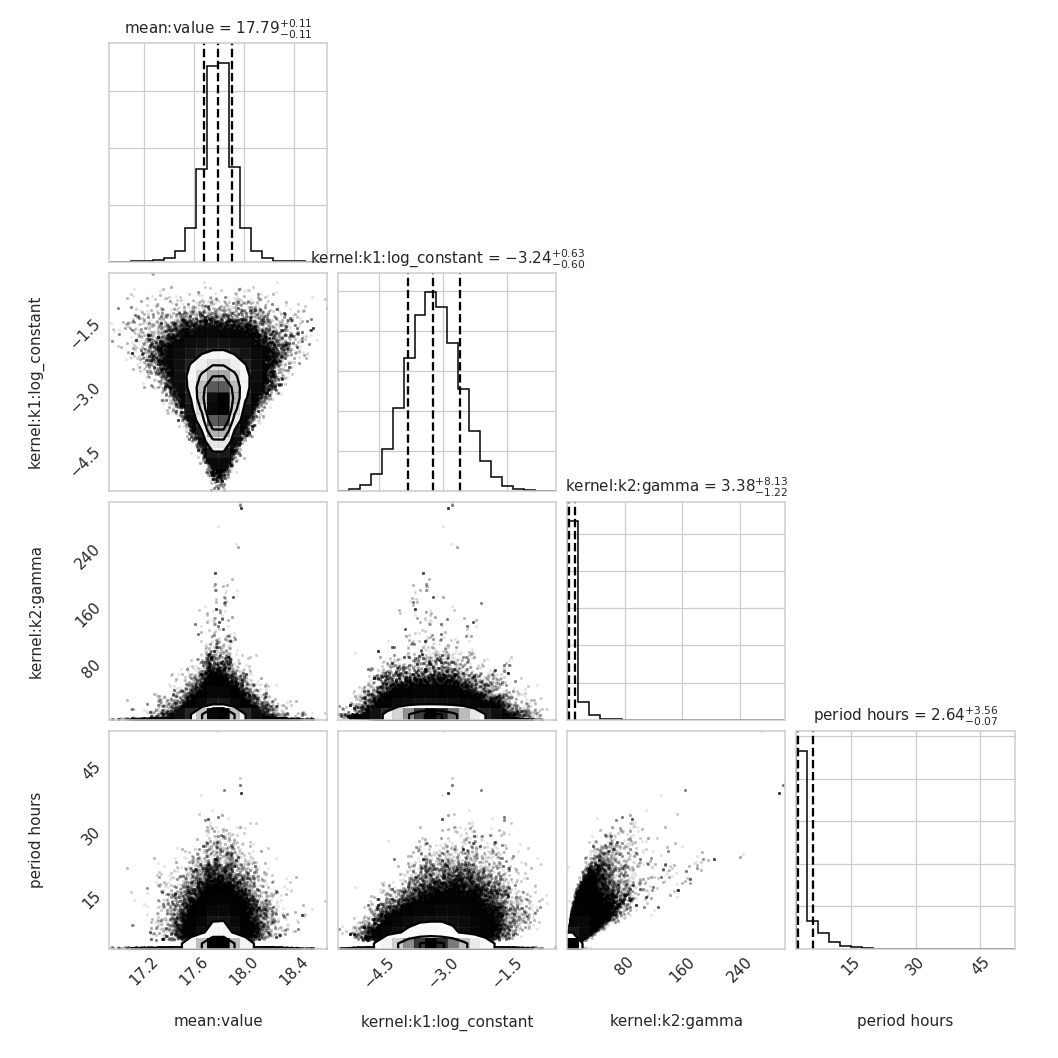

<IPython.core.display.Javascript object>


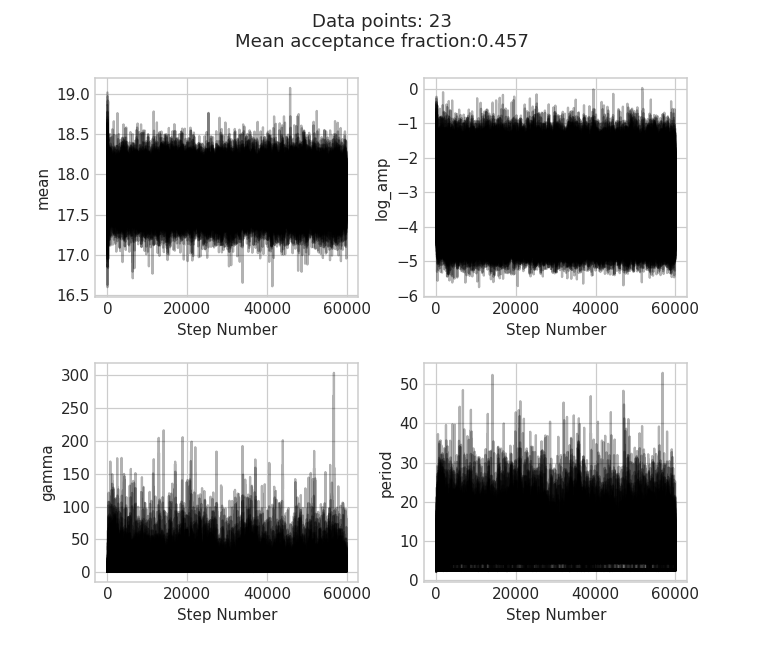

In [56]:
plot_mcmc_sampling_results(np.array(tsample), fsample, flux_err, gp, sampler, 
                           namestr="6478_60000steps" + "_plots", true_lightcurve=None, 
                           true_period=None)

###test failure with plotting if steps are too few

In [22]:
import gp_sandbox as cgp

<bound method GP.lnlikelihood of <george.gp.GP object at 0x7fbaa40847f0>>       fun: -44.99118040732159
 hess_inv: array([[ 2.18361208e-03, -5.59823966e-04,  4.82061084e-04,
         2.34625944e-05],
       [-5.59823966e-04,  3.41622171e-01, -4.36635850e-01,
         5.95384159e-05],
       [ 4.82061084e-04, -4.36635850e-01,  2.02576356e+00,
         8.21027552e-04],
       [ 2.34625944e-05,  5.95384159e-05,  8.21027552e-04,
         3.84713637e-04]])
      jac: array([-3.16354004e-07, -5.53379742e-09,  9.11364140e-09,  1.66927049e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 13
     njev: 18
   status: 0
  success: True
        x: array([17.79522084, -4.99355243,  3.78563356, -2.21812987]) 44.99118040732159


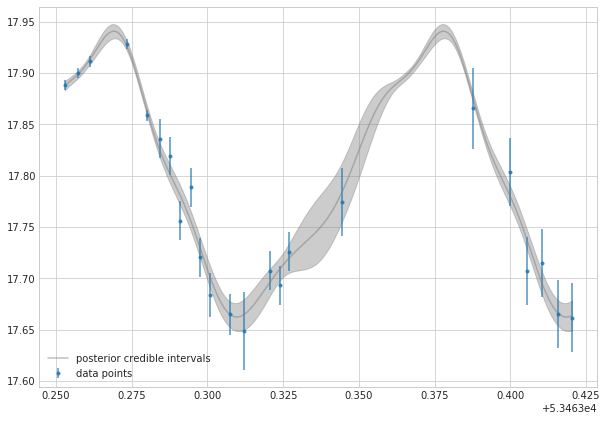

In [35]:
#import file into a pandas dataframe
df = pd.read_csv('../data/1291_lc_49627_to_49787.txt', delimiter=' ',header=None, names=['x','y'], dtype={'x':float, 'y':float})
pre_x = (df.x)
pre_y = df.y

cap = 1000

#sample only from the first 2000 points for x and y (out of 400,000ish...)
x, y, yerr = tsample, fsample, flux_err#cgp.sample_data(pre_x[0:cap], pre_y[0:cap], 1 , 0, 0, 1)  

#plot the two original points
plt.figure(figsize=(10, 7))
#plt.plot(pre_x[0:cap], pre_y[0:cap],  '.', alpha=0.5,label="Original")
plt.errorbar(x,y, yerr, alpha=0.8, fmt='.',label="data points")

#guess the kernel numbers 

#17.84250562 -3.75895736  4.09087516 -2.21950288
kernel = np.exp(-3.75895736)*george.kernels.ExpSine2Kernel(gamma=4.09087516, log_period=-2.21950288) #optimal gamma was ~15
gp = george.GP(kernel, fit_mean=True, mean=17.84250562)
gp.compute(x,yerr)
pred, pred_var = gp.predict(y, x, return_var=True)

#plot the kernel-fitted guess
#plt.fill_between(x, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="grey", alpha=0.4)
#plt.plot(x, pred, lw=1.5, alpha=0.7, label="Before")

x_short = np.linspace(x[0], x.iloc[-1], 1000)

#optimize the fit
gp2, ln_like2, result = cgp.optimize(y,gp,gp.lnlikelihood, print_results=True)
pred, pred_var = gp2.predict(y, x_short, return_var=True)

plt.fill_between(x_short, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="grey", alpha=0.4)
plt.plot(x_short, pred, "grey", lw=1.5, alpha=0.5, label="posterior credible intervals")
#plt.xlim([pre_x[0], pre_x[cap]])
plt.legend()

plt.savefig("6478" + "_plot_function_space.pdf", format="pdf")